### Two-Transition Path Kinetic Monte Carlo Simulation

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import scipy as sp

We first define the Hamiltonian in order to properly simulate the system.

We have a system with two basins $A$ and $B$, each with 3 microstates labeled as below:

$$ \{0,1,2\} \in A; \{3,4,5\} \in B $$

We arbitrarily define our reaction landscape such that Basin $A$ has a lower energy than Basin $B$.

Let the energy of basin $A$ defined as $E_A$, and the energy of basin $B$ defined as $E_B$.

The free energy of each basin $i$ can be written as:

$$ F_i = E_i - \beta^{-1} \log \Omega $$

where $\Omega$ is the number of microstates in each basin (here it is simply 3) and $\beta^{-1} = k_B T$.

Based on transition state theory, the reaction rate for a reaction $X \to Y$ is given by the Arrhenius rate equation:

$$ k_{X \to Y} \propto e^{-\beta \Delta F_{X \to Y} }$$

where $\Delta F_{X \to Y}$ is the height of the activation energy barrier (difference in free energy) in the direction $X \to Y$. 

Note that we also have transitions between microstates within a basin, albeit with a relatively small activation energy energy barrier. 

To specify our system entirely, we must thus define $F_I, F_{II}, F_A, F_B$ where $F_I$ and $F_{II}$ are the free energies of the saddle points in transition paths $I$ and $II$, and $F_A$ and $F_B$ correspond to the free energies of basins $A$ and $B$. In addition, we must also include the reaction rates within each basin: for simplicity, we make these activation energy heights the same across all basins:, on the order of $k_B T = \beta^{-1}$. 

To tune the height of the activation energy barrier for our two transition paths $I$ and $II$, we define two constants $\alpha_1$ and $\alpha_2$, which scale the activation energy barrier for transition paths $I$ and $II$ respectively. 

To simulate the system realistically, even though the true microstates all have the same energy, we add a noise term $\epsilon \sim \mathcal{N}(0,(.01\cdot\beta^{-1})^2)$ to the underlying true energy ($E_A$ or $E_B$) of our system.

Thus, we can now generate our 6-state MSM and the corresponding KMC transition matrix based on the energies we impose on our system.

A simple implementation of a 6-state MSM KMC simulation is given below, where we have the connections:

$$ 1 \to 3, 2 \to 4 $$

In [42]:
# generate 6-state MSM and corresponding transition matrix based on rates
from itertools import permutations 

beta = 10

e_a = 1/beta
e_b = 4/beta

alpha1 = 10
alpha2 = 5

def gen_MSM(alpha1,alpha2):
    # define free energies 
    f_A = e_a - 1/beta * np.log(3)
    f_B = e_b - 1/beta * np.log(3)

    # define free energies of states in basin A and B
    f_basinA = np.random.normal(loc=0,scale=.01/beta,size=3) + np.ones(3)*f_A
    f_basinB = np.random.normal(loc=0,scale=.01/beta,size=3) + np.ones(3)*f_B
    
    f_system = np.array([f_basinA, f_basinB]).flatten()
    
    for i in range(len(f_system)):
        print(f"Free energy of microstate {i}: {f_system[i]}")
    
    # we now calculate reaction rates based on these free energies assigned to our microstates:
    # our connections are as follows: 
    # 0<->1, 1<->2, 2<->0, 3<->4, 4<->5, 5<->3, 1<->3 (transition path 1), 2<->4 (transition path 2)
    
    deltaf_saddle1 = alpha1 / beta
    deltaf_saddle2 = alpha2 / beta
    deltaf_basin = 1 / beta
    
#     print(deltaf_saddle1, deltaf_saddle2)
    
    # generate probability transition matrix 
    P = np.zeros((6,6))
    for (i,j) in list(permutations(list(range(6)),r=2)):
        
        if i == j: # both states are the same
            rate_ij = 0
        elif i in list(range(3)) and j in list(range(3)): # both states are in basin A
            f_activation = max(f_system[i]+deltaf_basin,f_system[j]+deltaf_basin)
            rate_ij = np.exp(-beta*(f_activation-f_system[i]))
#             print(f'{i},{j},{f_activation}') 
        elif (i not in list(range(3)) and j in list(range(3))) or (i in list(range(3)) and j not in list(range(3))): # one is in A, the other is in B
            if (i == 1 and j == 3) or (i == 3 and j == 1):
                f_activation = max(f_system[i]+deltaf_saddle1,f_system[j]+deltaf_saddle1)
                rate_ij = np.exp(-beta*(f_activation-f_system[i]))
            elif (i == 2 and j == 4) or (i == 4 and j == 2):
                f_activation = max(f_system[i]+deltaf_saddle2,f_system[j]+deltaf_saddle2)
                rate_ij = np.exp(-beta*(f_activation-f_system[i]))
            else:
                rate_ij = 0
#             print(f'{i},{j},{f_activation}') 
        else: # both states are in basin B
            f_activation = max(f_system[i]+deltaf_basin,f_system[j]+deltaf_basin)
            rate_ij = np.exp(-beta*(f_activation-f_system[i]))
#             print(f'{i},{j},{f_activation}') 
        
        P[i,j] = rate_ij
        
    return P
        
gen_MSM(alpha_1,alpha_2)

Free energy of microstate 0: -0.008948107850882564
Free energy of microstate 1: -0.010613674409235347
Free energy of microstate 2: -0.008703739012656626
Free energy of microstate 3: 0.29040840056337686
Free energy of microstate 4: 0.2903698349330016
Free energy of microstate 5: 0.28978714378995396


array([[0.00000000e+00, 3.67879441e-01, 3.66981556e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.61802909e-01, 0.00000000e+00, 3.60919855e-01, 2.23734481e-06,
        0.00000000e+00, 0.00000000e+00],
       [3.67879441e-01, 3.67879441e-01, 0.00000000e+00, 0.00000000e+00,
        3.38584881e-04, 0.00000000e+00],
       [0.00000000e+00, 4.53999298e-05, 0.00000000e+00, 0.00000000e+00,
        3.67879441e-01, 3.67879441e-01],
       [0.00000000e+00, 0.00000000e+00, 6.73794700e-03, 3.67737593e-01,
        0.00000000e+00, 3.67879441e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.65601050e-01,
        3.65742073e-01, 0.00000000e+00]])

In [56]:
# define transition matrix
P = gen_MSM(alpha1,alpha2)
print(P)
P.shape

Free energy of microstate 0: -0.011256228866484388
Free energy of microstate 1: -0.00886734782603811
Free energy of microstate 2: -0.009429632157401929
Free energy of microstate 3: 0.2884027322764716
Free energy of microstate 4: 0.2899496686670319
Free energy of microstate 5: 0.28966178922016966
[[0.00000000e+00 3.59195378e-01 3.61220766e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.67879441e-01 0.00000000e+00 3.67879441e-01 2.32288456e-06
  0.00000000e+00 0.00000000e+00]
 [3.67879441e-01 3.65816717e-01 0.00000000e+00 0.00000000e+00
  3.37551317e-04 0.00000000e+00]
 [0.00000000e+00 4.53999298e-05 0.00000000e+00 0.00000000e+00
  3.62232371e-01 3.63276666e-01]
 [0.00000000e+00 0.00000000e+00 6.73794700e-03 3.67879441e-01
  0.00000000e+00 3.67879441e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.67879441e-01
  3.66821915e-01 0.00000000e+00]]


(6, 6)

In [50]:
# implement KMC without rejection and define helper functions
def kmc(P: np.array, epochs: int,init_state: int):
    
    init_vec_t0 = np.array([int(j == init_state) for j in range(P.shape[0])]) # one-hot vector 
    
    R_ki = np.cumsum(P,axis=1) # returns matrix of cumulative functions 
    
    Q_k = R_ki[:,-1] # total rates
    
    curr_vec = init_vec_t0
    
    states_list = [init_state]            # to keep track of state values
    states_matrix = [init_vec_t0]           # matrix to keep track of state vectors
    times = [0]                           # to keep track of timesteps
    
    prob_vector = init_vec_t0
    
    for _ in range(epochs):
        
        k = np.argwhere(curr_vec == 1)[0][0]
        
        u = np.random.uniform() # generate random number from uniform distribution
        
        # we now want to find i such that R_{k,i-1}< u * Q_{k} <= R_{ki} 
        
        i = np.searchsorted(R_ki[k,:], u*Q_k[k])
        states_list.append(i)
        
        curr_vec = np.array([int(j == i) for j in range(P.shape[0])]) # transition state
        states_matrix.append(curr_vec)
        
        v = np.random.uniform() # draw uniform number for timestep
        times.append(times[-1] + 1/Q_k[k] * np.log(1/v))
        
    return np.array(times), np.array(states_list), np.array(states_matrix).T

def probabilities(state_matrix):
    return np.sum(state_matrix,axis=1) / state_matrix.shape[1]

In [68]:
times, states, state_matrix = kmc(P,epochs=100000,init_state=0)

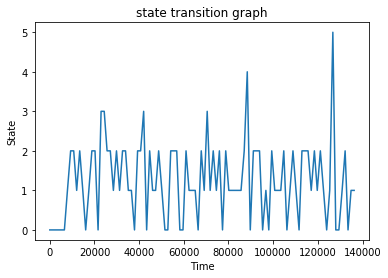

In [73]:
# plotting 
plt.plot(times[::1000],states[::1000],'-')
plt.title(f'state transition graph')
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

In [74]:
times, states, state_matrix = kmc(P,epochs=100000,init_state=0)
probabilities(state_matrix)

array([0.31596684, 0.31425686, 0.31722683, 0.01778982, 0.01747983,
       0.01727983])

### Unit Test:

We now check the correctness of our KMC simulation by comparing the simulated probabilities to the equilibrium probabilities predicted by the Boltzmann distribution.

For a Hamiltonian $\mathcal{H}$, the probability of a state $\omega$ is given by:

$$ p(\omega) \propto \exp\{-\beta \cdot \mathcal{H}(\omega)\} $$

Here, we have $E_A = \beta^{-1} = .01$, $E_B = 4 \cdot \beta^{-1}$.

Thus, in the absence of noisy microstates, the equilibrium probabilities should come out to:

$$p(A) = \frac{e^{-1}}{e^{-1}+ e^{-4}} \approx 0.953$$, $$p(B) = \frac{e^{-4}}{e^{-1}+ e^{-4}} \approx 0.047$$.

with a relative ratio of:

$$ \frac{p(A)}{p(B)} = \frac{e^4}{e^1} = e^3 \approx 20.085$$

We now test our simulation with $\beta = 10$ and 50 trials to see whether we indeed recover these equilibrium probabilities:

In [ ]:
num_trials = 50

avg_prob = 0
for _ in range(num_trials):
    times, states, state_matrix = kmc(P,epochs=100000,init_state=0)
    prob_array = probabilities(state_matrix)
    avg_prob += prob_array / num_trials
    avg_prob_A = prob_array[0] + prob_array[1] + prob_array[2]
    avg_prob_B = prob_array[3] + prob_array[4] +prob_array[5]
    
print("Average equilibrium probability distribution (including microstates ):", avg_prob)
print("Average equilibrium probability of state A: ", avg_prob_A)
print("Average equilibrium probability of state B: ", avg_prob_B)